In [1]:
%matplotlib inline

import chb
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [3]:
chb01list = chb.summary('chb01')

In [4]:
alldata = chb.load_data(chb01list, True, False)

Loading: /Users/adamcellon/Drive/senior/thesis/data/chb01.npz
Done.


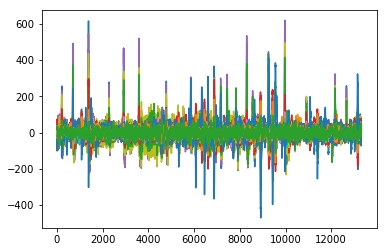

In [5]:
for i in range(alldata[0].rec.shape[0]):
    plt.plot(alldata[0].rec[i,92672:105984])

In [6]:
labeled = chb.label(alldata)

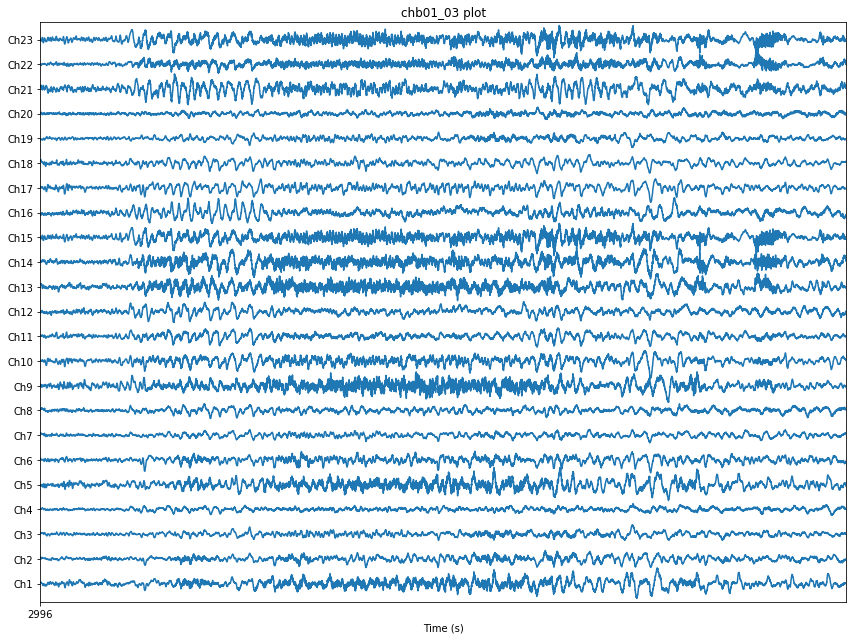

In [11]:
labeled[2].plot(start=labeled[2].start[0], end=labeled[2].end[0])

In [9]:
masked = labeled[2].rec * labeled[2].ict

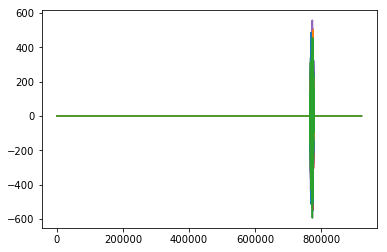

In [10]:
for i in range(masked.shape[0]):
    plt.plot(masked[i,:])

In [11]:
masked[:,masked[0,:]!=0].shape

(23, 10240)

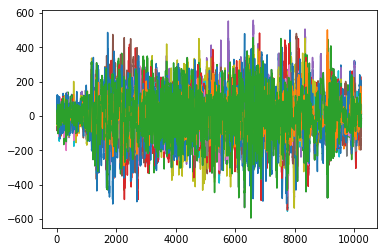

In [12]:
for i in range(masked.shape[0]):
    plt.plot(masked[i,masked[0,:]!=0])

In [13]:
masked2 = labeled[2].rec * (labeled[2].ict + labeled[2].preict)

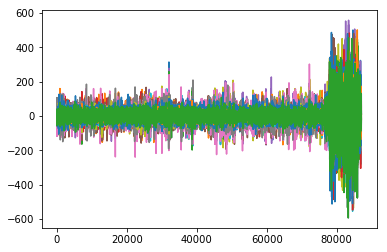

In [14]:
for i in range(masked2.shape[0]):
    plt.plot(masked2[i,masked2[0,:]!=0])

In [15]:
masked2[:,masked2[0,:]!=0].shape

(23, 87040)

In [32]:
t

array([  0.00000000e+00,   3.90625000e-03,   7.81250000e-03, ...,
         3.59998828e+03,   3.59999219e+03,   3.59999609e+03])